# Summary dataset analysis
The goal of this analysis is to explore the summary dataset, detect abnormalities within this dataset, and filter for relevant data for the later analysis. 

The `summary` dataframe is one of several in the Kaggle Stock Earnings dataset. It contains aggregate data based on the contents of the `earnings` and `prices` files.
* `earnings` table provides ticker symbol along with the `date` and `release_time` 
when `eps_est` (earnings per share estimate) and `eps` (actual earnings per share) being released
* `prices` table provides information about the stock prices, including columns such as 
`date` , `open`, `high`, `low`, `close`, `close_adjusted`, `volume`, and `split_coefficient`.

A better understanding of this table will facilitate the process of combining those datasets for analysis and modeling.

This notebook presents the process of exploring the summary dataset and key insights discovered along the way.

In [1]:
# data analysis, wrangling and preprocessing
import numpy as np 
import pandas as pd

# deal with datetime object
import datetime

# data visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

## Loading Data
We start by loading the datasets into Pandas DataFrames.

In [2]:
summary = pd.read_csv('/kaggle/input/us-historical-stock-prices-with-earnings-data/dataset_summary.csv', parse_dates=['stock_from_date','stock_to_date','earnings_from_date','earnings_to_date'])

## Exploratory Data Analysis
We use exploratory data analysis (EDA) to identify trends, anomalies, patterns, and possible relationships within the given data, using plots. It will help us determine if there are columns that don't have enough records and identify possible features we could put into our models or use as keys when we try to combine datasets later on. 

* We start off with **univariate analysis**, aiming to understand the distribution of underlying variable. 
Through this process, we can identify which one of the distributions the variable most closely represents, 
which helps with the model selection process later on. 
* Univariate analysis also helps us discover possible outliers that could have a large impact on the 
overall distribution. 
* Since we have multiple datetime obejects, we also have to consider **univariate time series analysis**. 
In this analysis, we will look at the change of a variable across a time period and their volitility 
and underlying distribution across different granularity of time. 

* Then, we can proceed to **bivariate analysis**, where we plan to explore the potentail relationship between two variables. Similiarly, we will look at bivariate analysis across a time period. 

## Summary table

These are the following fields in the `summary` dataset.

* `symbol`: This is the ticker of the stock.

* `total_prices`: This is the number of records this particular ticker has in the stock prices dataset. 

* `stock_from_date`: The earliest date a price is available for this ticker in the price dataset. 

* `stock_to_date`: The latest date a price is available for this ticker in the price dataset.

* `total_earnings`: The number of records corresponding to this particular ticker in the earnings dataset.

* `earnings_from_date`: The earliest date earnings are available for this ticker in the earnings data.

* `earnings_from_date`: The latest date earnings are available for this ticker in the earnings data.

### Examine the number of stocks in this dataset with unique `symbol`

Let's first examine how many unique stocks are in this dataset.

In [3]:
unique_symbol = len(summary['symbol'].unique())
print(f'The unique number of stocks in the summary dataset is {unique_symbol}')

The unique number of stocks in the summary dataset is 7786


In [4]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7786 entries, 0 to 7785
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   symbol              7786 non-null   object        
 1   total_prices        7786 non-null   int64         
 2   stock_from_date     7786 non-null   datetime64[ns]
 3   stock_to_date       7786 non-null   datetime64[ns]
 4   total_earnings      7786 non-null   int64         
 5   earnings_from_date  5150 non-null   datetime64[ns]
 6   earnings_to_date    5150 non-null   datetime64[ns]
dtypes: datetime64[ns](4), int64(2), object(1)
memory usage: 425.9+ KB


We have the correct data type for each column. 

Since we have 7786 entries and there are only 5150 non-null entries in the `earnings_from_date`
and `earnings_to_date`, these two columns have missing data. 
It's important to deal with them before our analysis because they will raise errors 
during the process of combining `summary` dataset with `earnings` dataset later on.

Since `total_prices` and `total_earnings` from the summary table don't have any missing values. 
We can start our analysis. 

### Examine the distribution of `stock_from_date` across different years:

We want to find if there is a pattern in the distribution of `stock_from_date` across different years 
and check if there is some abnomalities for this distribution. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 <a list of 23 Text major ticklabel objects>)

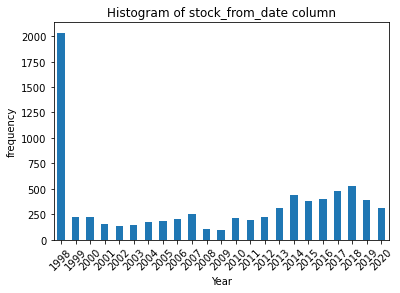

In [5]:
summary['stock_from_year'] = summary.apply(lambda row: row['stock_from_date'].year, axis=1)
df = summary['stock_from_year'].value_counts().rename_axis('year').reset_index(name='counts')
df.set_index('year').sort_values(by=['year']).plot(kind='bar', legend=None)
plt.xlabel('Year')
plt.ylabel('frequency')
plt.title('Histogram of stock_from_date column')
plt.xticks(rotation=45)

Based on the plot: 
* A major outlier occurs in 1998. 
This could be explained by the limitation of the dataset in which it contains stocks around 
the 20-year period. 
`stock_from_date` column of stocks that were listed before 1998 is censored. 
* The trend of the number of companies being listed on the market across different years. 
It has a general upward trend until declining in 2019 and 2020. 
* The global financial crisis was the major factor that contribute to the drop-off in the number of IPOs 
in 2008 and 2009. 
* The global pandanmic was the major reason to the drop-off in the number of IPOs in 2019 and 2020.


#### Investigate further into the distribution of `stock_from_date` across different quarter:
We want to see if seasonality plays a part in the number of IPOs across time. We selected 'quarter' 
as the granularity of time. 

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

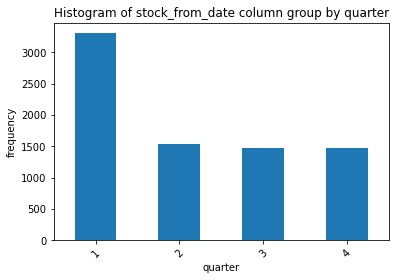

In [6]:
summary['stock_from_quarter'] = summary.apply(lambda row: row['stock_from_date'].quarter, axis=1)
df = summary['stock_from_quarter'].value_counts().rename_axis('quarter').reset_index(name='counts')
df.set_index('quarter').sort_values(by=['quarter']).plot(kind='bar', legend=None)
plt.xlabel('quarter')
plt.ylabel('frequency')
plt.title('Histogram of stock_from_date column group by quarter')
plt.xticks(rotation=45)

According to the bar chart above, the first quarter seems to have twice as many total_prices as other quarters, which is irregular in the datasets. Our explanation for this to happen is that `stock_from_year` equals to 1998 has a major impact on the distribution of `total_prices` across different quarters.

We will try to validate this by filtering out the `total_prices` that are in 1998 and see how the bar chart looks without them:

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

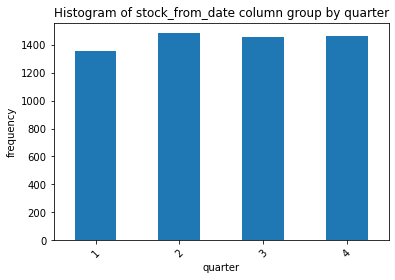

In [7]:
summary_ = summary[summary['stock_from_year'] != 1998]
df = summary_['stock_from_quarter'].value_counts().rename_axis('quarter').reset_index(name='counts')
df.set_index('quarter').sort_values(by=['quarter']).plot(kind='bar', legend=None)
plt.xlabel('quarter')
plt.ylabel('frequency')
plt.title('Histogram of stock_from_date column group by quarter')
plt.xticks(rotation=45)

Without the interferencing from `total_prices` in 1998, we can see `total_prices` are evenly distributed in different quarters. If we want to use `total_prices` from 1998, we might have to sample some of them to make sure that `total_prices` from 1998 don't weight too much in our analysis.

### Examine the distribution of `earnings_from_date` across year:
We want to see if there is any irregularities in the distribution of `earnings_from_date` across
different years.

In [8]:
summary['earnings_from_date'].min()

Timestamp('2009-04-16 00:00:00')

The limitation of the dataset from the `summary` dataset is that it only contains earnings 
for stocks since 2009. That is the earliest time available for analysis was in 2009 compared 
to 1998 (the earliest time for `stock_from_year` in the previous analysis).

In [9]:
# Create a new dataframe, containing the actual IPOs in a year since 2009
# Sources: https://stockanalysis.com/ipos/statistics/
year_range = np.arange(2009,2021,1)
ipos = [79,190,171,157,251,304,206,133,217,255,233,480]
ipo = pd.DataFrame({'year' : year_range, 'ipos':ipos})

In [10]:
summary['earnings_from_year'] = summary.apply(lambda row: row['earnings_from_date'].year, axis=1)
df = summary['earnings_from_year'].value_counts().rename_axis('year').reset_index(name='counts')
df['year'] = df['year'].astype(int)
df = df.set_index('year').sort_values(by=['year'])

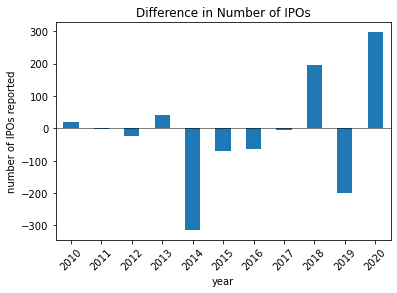

In [11]:
comp = pd.merge(ipo, df, on="year")
comp['diff'] = comp['ipos'] - comp['counts']
comp = comp[['year','diff']]
comp = comp.set_index('year')
comp = comp.iloc[1:,:]
comp.plot(kind='bar', legend=None)
plt.xticks(rotation=45)
plt.ylabel('number of IPOs reported')
plt.title('Difference in Number of IPOs')
plt.axhline(y=0, linewidth=0.5, color='black')

In order to check the completeness of the summary dataset, we crossed check the
data provided with another online source: https://stockanalysis.com/ipos/statistics/.

The bar chart above shows the different in the number of IPOs the summary data provides and 
the number of actual IPOs the alternative source provides.

We filtered out data from 2009 because the data before 2009 is censored. 
We notice that the data from the `summary` dataset has some inconsistencies with the actual number
of IPOs throughout the years. 

We have to note that the `summary` dataset is not the complete representation of stocks throughout
the years. It's an open question to anyone who are interested in this dataset to investigate this further.

#### Investigate further into the distribution of `earnings_from_date` across weekdays:
We want to see if there is a general trend of `earnings_from_date` across different time granularity, such as 
weekdays. It's more likely for companies to continue announcing their earnings on a specific 
weekday after making the first announcement on that weekday.

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

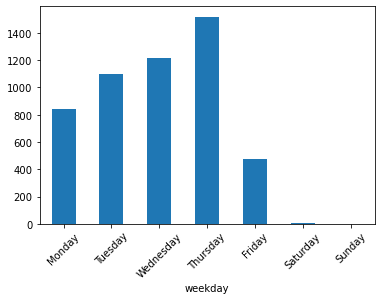

In [12]:
summary['earnings_from_weekday'] = summary.apply(lambda row: row['earnings_from_date'].weekday(), axis=1)
df = summary['earnings_from_weekday'].value_counts().rename_axis('weekday').reset_index(name='counts')
df = df.set_index('weekday').sort_values(by=['weekday'])
df.rename(index={0.0:'Monday',1.0:'Tuesday',2.0:'Wednesday',3.0:'Thursday',4.0:'Friday',5.0:'Saturday',6.0:'Sunday'},inplace=True)
df.plot(kind='bar', legend=None)
plt.xticks(rotation=45)

Based on the distribution of `earnings_from_date` across weekdays, 
we can see that most of the companies in our datasets report their **first** earnings on a Thursday.
Starting with Monday, more and more companies report their earnings throughout the week. 
We have also notice that fewer companies reported their earnings on a Friday in the time 
frame of this dataset. 
And almost no companies reported their earnings on weekends except few companies on Saturday, 
which we may have to look into why they reported their earnings on a Saturday.

Since companies from 2009 may have a huge weight in this plot, 
we are going to eliminate those companies and see how the distribution look like:

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

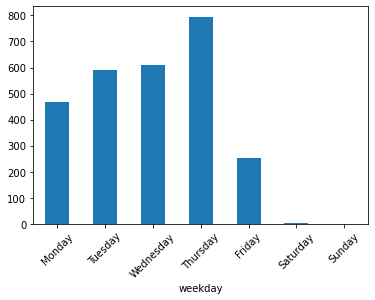

In [13]:
summary['earnings_from_year'] = summary.apply(lambda row: row['earnings_from_date'].year, axis=1)
summary_ = summary[summary['earnings_from_year'] != 2009]
df = summary_['earnings_from_weekday'].value_counts().rename_axis('weekday').reset_index(name='counts')
df = df.set_index('weekday').sort_values(by=['weekday'])
df.rename(index={0.0:'Monday',1.0:'Tuesday',2.0:'Wednesday',3.0:'Thursday',4.0:'Friday',5.0:'Saturday',6.0:'Sunday'},inplace=True)
df.plot(kind='bar', legend=None)
plt.xticks(rotation=45)

We don't see much change in the distribution of `total_earnings` across weekdays change
much after we filter out companies with `total_earnings` from 2009.

Since `earnings_from_date` column only provides the first earnings release date for
a specific company, we have to use `earnings` dataset to see if there is a pattern in the 
weekday when companies release their earnings.

### Examine the distribution of `total_prices` column
We want to understand the distribution of `total_prices` to see if there are any irregularities
we have to address.

Text(0.5, 1.0, 'Histogram of total_prices column')

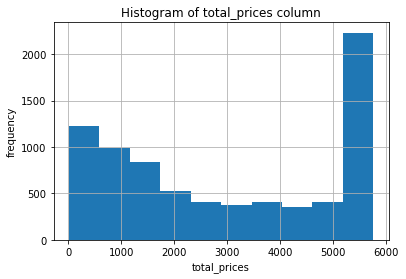

In [14]:
summary['total_prices'].hist()
plt.xlabel('total_prices')
plt.ylabel('frequency')
plt.title('Histogram of total_prices column')

There are a number of takeaways from this chart:

* `total_prices` is bimodal, with concentrations at 0 and 5500.
* The mode at 0 is due to the fact these stocks do not have price data.
* The mode at 5500 is due to the fact that our dataset begins in 1998, 
so securities that have price data before that are censored.

We identified the `total_price` column to be right-censored.
The censoring of the data is a potential issue because the observed value of the 
`total_prices` is partially known. In this case, we don't know the price of stocks before 1998. 

### Examine the distribution of `total_earnings` column
We want to understand the distribution of `total_earnings` to see if there are any irregularities
we have to address.

Text(0.5, 1.0, 'Histogram of total_earnings column')

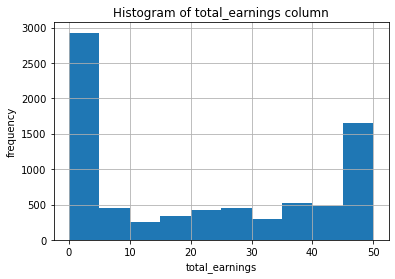

In [15]:
summary['total_earnings'].hist()
plt.xlabel('total_earnings')
plt.ylabel('frequency')
plt.title('Histogram of total_earnings column')

There are a number of takeaways from this chart:
* `total_earnings` is bimodal with two concentrations at 0 and 45. 
* The peak at 45 represents the number of companies that we have all of their earnings data
in the time slot of the dataset
* The peak at 0 says that there are a lot of companies that have very limited number of
earnings available for our analysis. 

We consider a cut-off point where we can obtain companies with enough earnings for analysis. 

### Examine the joint distribution of `earnings_from_date` and `stock_from_date`
Since we can't make joint distribution from datetime objects, we will transform these two columns into `earnings_years` and `stock_years`, which corresponding to the number of days since.

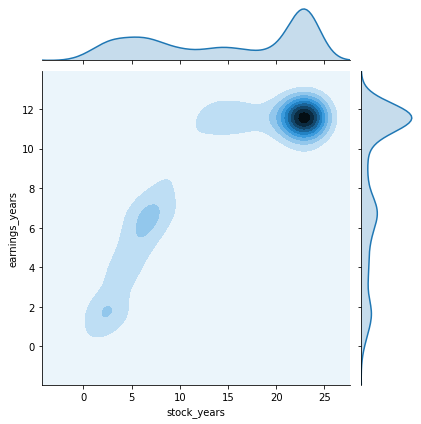

In [16]:
summary['earnings_years'] = datetime.datetime.now() - summary['earnings_from_date']
summary['earnings_years'] = summary.apply(lambda row: row['earnings_years'].days / 365, axis=1)
summary['stock_years'] = datetime.datetime.now() - summary['stock_from_date']
summary['stock_years'] = summary.apply(lambda row: row['stock_years'].days / 365, axis=1)
sns.jointplot(data=summary,x='stock_years',y='earnings_years', kind='kde')

One thing to note before going into the takeaways from this plot is that the contour plot goes
into the negative territory for a specific region. This is one of the limitations of the kde plot
because of the concentration of data points in that region. 

There are several takeaways from this joint plot:
* It's been around 12 years since most of the earnings are started to be reported 
* It's been around 25 years since most of the prices are started to be reported in these datasets. 
* The discrepancy in the two bullet points above means that we don't necessarily have 
earnings and price data for a period of time. 
* For our analysis, we need both earnings and price data of a particular stock to measure the 
price leading up to the earnings announcement and the reaction of the stock prices after the 
earnings announcement. 

### Examine joint distribution of `total_prices` and `total_earnings`
To find out the distribution for earnings and prices at the same time, 
we decided to use the joint distribution to plot earnings and prices on the same plot. 
We decided to use hex plot just because there might be some misunderstanding for negative 
values in the previous contour plot.

We expect a positive relationship between `total_prices` and `total_earnings` for this 20-year period. 
That is, a company with more `total_earnings` will have more `total_prices`. 

Text(4300, 38, 'Group 3')

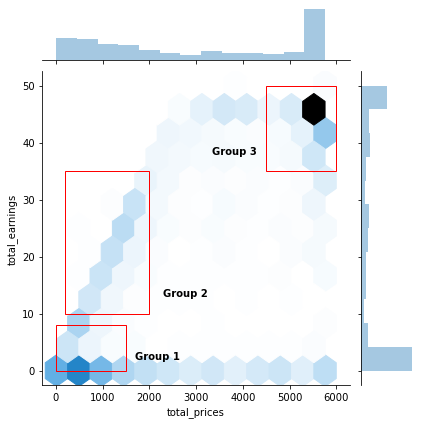

In [17]:
g = sns.jointplot(data=summary,x='total_prices',y='total_earnings',kind='hex')
ax = g.ax_joint
ax.add_patch(Rectangle((4500, 35), 1500, 15, fill=False, edgecolor='red', lw=1))
ax.add_patch(Rectangle((0, 0), 1500, 8, fill=False, edgecolor='red', lw=1))
ax.add_patch(Rectangle((200, 10), 1800, 25, fill=False, edgecolor='red', lw=1))
ax.text(1700, 2, "Group 1", horizontalalignment='left', size='medium', color='black', weight='semibold')
ax.text(2300, 13, "Group 2", horizontalalignment='left', size='medium', color='black', weight='semibold')
ax.text(4300, 38, "Group 3", horizontalalignment='right', size='medium', color='black', weight='semibold')

As you can see in the histograms on the top and on the side of the joint distribution, 
there are a large number of companies that have zero `total_prices` when the `total_earnings` 
is zero (Group 1). These records won't be helpful for our model.

While we exclude the records where the `total_earnings` is not zero, `total_prices` caps at 
around 5500. This will useful because we can set a range where we only investigate stocks with 
more than a certain threshold of `total_prices`. We can filter out record below that threshold 
because they lack necessary information.

According to the joint distribution, `total_prices` and `total_earnings` are not normally 
distributed, we can see distinct clusters at the bottom left (Group 1) and top right corners 
(Group 3). 
`total_earnings` has a bimodal distribution with two peaks at 0 and 45. 
`total_prices` has a bimodal distribution with two peaks at 0 and 5500. 

Most of the data fill into the Group 3 as we annotated on the plot, which we expect. 
This is because most of the companies have reported their earnings consistently. 
However, the cluster in the left corner is the abnormality we discovered from this plot. 
Those hex boxes don't have enough earnings nor prices available for analysis. 

An interesting trend can be seen from the plot where the `total_earnings` increase as 
the `total_earnings` increase (Group 2). 
A plausible explanation for this is that those companies went public later than 1998 and 
are on their way to join the majority of companies that have sound records. 
As time goes on, we expect the cluster at the right upper corner to move further and 
further away diagonally.

In order to get the necessary data with enough records for analysis, 
we need to filter our data based on total_prices and total_earnings to get the companies that 
locate at the right upper corner of our joint distribution because they have enough 
`total_earnings` and `total_prices` for further analysis.
